# PS3 - Interpretability

## Part 2: Evaluate an interpretability method

### Distill-and-compare: Auditing black-box models using transparent model distillation.

In [76]:
import os
import pickle
import random
from tqdm import tqdm

import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset

from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
#from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

from confidenceinterval import roc_auc_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

import numpy as np
import pandas as pd
from pygam import LogisticGAM, s

### Load MIMIC Dataset

In [77]:
mimic_data = pd.read_csv('../cph200c_proj2/Data/mimic_data_incl_dummies.csv')

display(mimic_data.head())
mimic_data['female']=(mimic_data['gender']=='F').astype(int)
print(mimic_data.shape)
dummies = pd.get_dummies(mimic_data['race'])
mimic_data = pd.concat([mimic_data, dummies], axis=1)
print(mimic_data.shape)


,Unnamed: 0,subject_id,hadm_id,admittime,real_admit_year,age,gender,race,mortality,readmission,...,ICD9_990.1,ICD9_991.1,ICD9_992.1,ICD9_993.1,ICD9_994.1,ICD9_995.1,ICD9_996.1,ICD9_997.1,ICD9_998.1,ICD9_999.1
0,0,10000032,22595853,2180-05-06,2014,52,F,WHITE,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,10000032,22841357,2180-06-26,2014,52,F,WHITE,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,10000032,25742920,2180-08-05,2014,52,F,WHITE,0,1,...,0,0,0,0,0,0,0,0,0,0
3,3,10000068,25022803,2160-03-03,2008,19,F,WHITE,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,10000117,27988844,2183-09-18,2017,57,F,WHITE,0,0,...,0,0,0,0,0,0,0,0,0,0


(233952, 4086)
(233952, 4119)


In [78]:
mimic_in_distribution = mimic_data[(mimic_data['real_admit_year']>=2008) & (mimic_data['real_admit_year']<=2013)]

mimic_in_14_16 = mimic_data[(mimic_data['real_admit_year']>2013) & (mimic_data['real_admit_year']<=2016)]
mimic_in_17_20 = mimic_data[(mimic_data['real_admit_year']>2016) & (mimic_data['real_admit_year']<=2020)]
mimic_in_20 = mimic_data[(mimic_data['real_admit_year']>2019) & (mimic_data['real_admit_year']<=2020)]
print(mimic_in_distribution.shape)
print(mimic_in_14_16.shape)
print(mimic_in_17_20.shape)

print(list(mimic_in_distribution.columns)[:20])

test_df = mimic_in_distribution[['age','female','race']]
# Calculate the number of missing values per column
missing_values = test_df.isnull().sum()
print(missing_values)

(132271, 4119)
(57459, 4119)
(44161, 4119)
['Unnamed: 0', 'subject_id', 'hadm_id', 'admittime', 'real_admit_year', 'age', 'gender', 'race', 'mortality', 'readmission', 'diagnoses', 'procedure', 'ICD10_A01', 'ICD10_A02', 'ICD10_A03', 'ICD10_A04', 'ICD10_A05', 'ICD10_A07', 'ICD10_A08', 'ICD10_A09']
age       0
female    0
race      0
dtype: int64


In [79]:
# Define the columns to exclude
exclude_columns = ['Unnamed: 0', 'subject_id', 'hadm_id', 'admittime', 'real_admit_year', 'gender', 'race', 'readmission', 'mortality', 'diagnoses', 'procedure']

# Define the target variable
y = mimic_in_distribution['mortality']

# Define the feature variables by excluding the columns in the exclude list
X = mimic_in_distribution.drop(columns=exclude_columns)

# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the resulting datasets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Standardize the features for LASSO
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

###############################################
####### For out of distribution data

# 14-16 data
y_14_16 = mimic_in_14_16['mortality']
X_14_16 = mimic_in_14_16.drop(columns=exclude_columns)
X_14_16 = scaler.transform(X_14_16)

# 17-20 data
y_17_20 = mimic_in_17_20['mortality']
X_17_20 = mimic_in_17_20.drop(columns=exclude_columns)
X_17_20 = scaler.transform(X_17_20)

X_train shape: (105816, 4108)
X_test shape: (26455, 4108)
y_train shape: (105816,)
y_test shape: (26455,)


Using the complete dataset for PS3

In [80]:
mimic_ps3_data = mimic_data[(mimic_data['real_admit_year']>=2008) & (mimic_data['real_admit_year']<=2020)]

# Define the columns to exclude
exclude_columns = ['Unnamed: 0', 'subject_id', 'hadm_id', 'admittime', 'real_admit_year', 'gender', 'race', 'readmission', 'mortality', 'diagnoses', 'procedure']

# Define the target variable
y = mimic_ps3_data['mortality']

# Define the feature variables by excluding the columns in the exclude list
X = mimic_ps3_data.drop(columns=exclude_columns)

# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features for LASSO
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### PS3 Distillation Modelling

#### Step 1: Fit different black-box model and show their performance at predicting the label of interest


In [6]:
log_reg_bb = LogisticRegression(random_state=42)
log_reg_bb.fit(X_train_scaled, y_train)

y_pred_lr = log_reg_bb.predict_proba(X_test_scaled)[:, 1]
auc_lr = roc_auc_score(y_test, y_pred_lr)
auc_lr, ci_lr = roc_auc_score(y_test,
                        y_pred_lr,
                        confidence_level=0.95)

print(f'Logistic Regression Model AUC (in distribution): {auc_lr:.3f} ({ci_lr[0]:.3f}, {ci_lr[1]:.3f})')

/home/alexberkeley/miniconda3/envs/cph200c_2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Regression Model AUC (in distribution): 0.954 (0.947, 0.961)


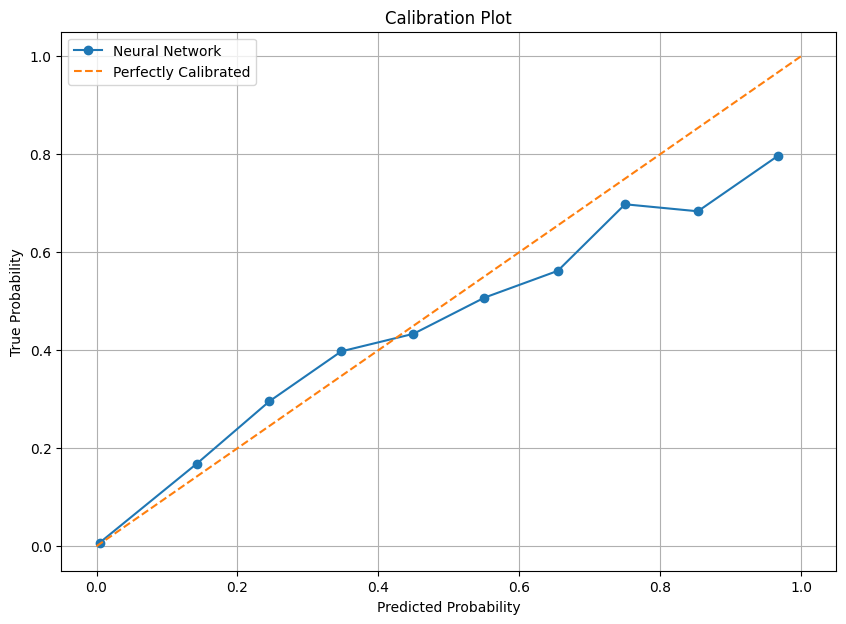

In [214]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# Calculate calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_pred_lr, n_bins=10)

# Plot calibration curve
plt.figure(figsize=(10, 7))
plt.plot(prob_pred, prob_true, marker='o', linestyle='-', label='Neural Network')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.title('Calibration Plot')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.legend()
plt.grid()
plt.savefig('lr_calibration_before.png')
plt.show()

(187112,)
(187112,)
True
[0.00298123 0.12744534 0.24215686 0.3537037  0.46315789 0.55268817
 0.61815754 0.77235772 0.86181818 0.93353705]


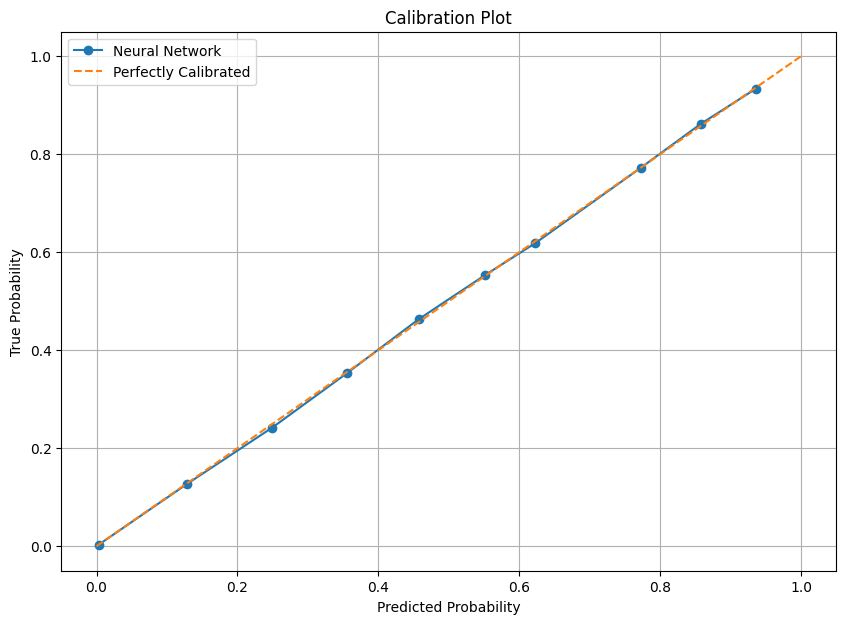

[0.00585658 0.13146552 0.26501767 0.35497835 0.43404255 0.46938776
 0.55621302 0.66492147 0.70542636 0.84384384]


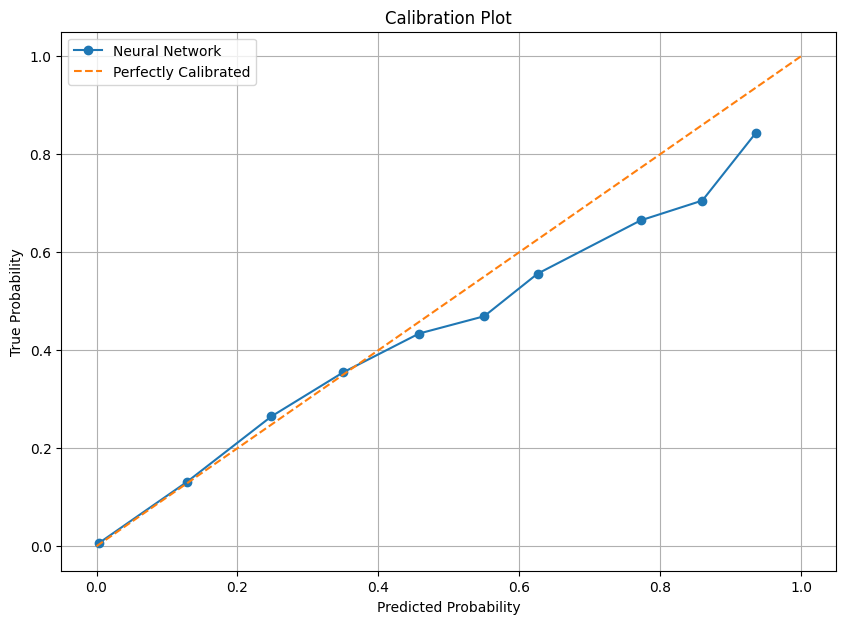

Logistic Regression Model AUC: 0.954 (0.947, 0.961)
Logistic Regression Model AUC: 0.954 (0.947, 0.961)


In [215]:
y_pred_lr_train = log_reg_bb.predict_proba(X_train_scaled)[:, 1]

print(y_train.shape)
print(y_pred_lr_train.shape)

# Create a DataFrame
data = pd.DataFrame({'outcome': y_train, 'score': y_pred_lr_train})

# Fit a Logistic GAM model
gam = LogisticGAM(s(0)).fit(data['score'], data['outcome'])
spnow = gam.lam

# Predict using the GAM model
y_pred_lr_train_calib = gam.predict_proba(data['score'])

# Check if the model is monotonic
def is_monotonic(predictions, outcomes, n_bins=10):
    prob_true, prob_pred = calibration_curve(outcomes, predictions, n_bins=n_bins)
    return np.all(np.diff(prob_true) >= 0)

print(is_monotonic(y_pred_lr_train_calib, y_train, n_bins=10))

if not is_monotonic(y_pred_lr_train_calib, y_train, n_bins=10):
    print("GAM not yet monotonic, tune!!!")
    # Tune smoothing parameter to achieve monotonicity
    tunes = np.logspace(-3, 3, 10)
    for tune in tunes:
        tune = float(tune)
        gam = LogisticGAM(s(0),lam=spnow[0][0]*tune).fit(data['score'], data['outcome'])
        y_pred_lr_train_calib = gam.predict_proba(data['score'])
        if is_monotonic(y_pred_lr_train_calib, y_train, n_bins=10):
            print(f"Monotonicity achieved with sp = {spnow[0][0] * tune}")
            break

# Use the final calibrated predictions
y_pred_lr_test_calib = gam.predict_proba(y_pred_lr)

# Calculate calibration curve
prob_true, prob_pred = calibration_curve(y_train, y_pred_lr_train_calib, n_bins=10)
print(prob_true)

# Plot calibration curve
plt.figure(figsize=(10, 7))
plt.plot(prob_pred, prob_true, marker='o', linestyle='-', label='Neural Network')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.title('Calibration Plot')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.legend()
plt.grid()
plt.show()

# Calculate calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_pred_lr_test_calib, n_bins=10)
print(prob_true)

# Plot calibration curve
plt.figure(figsize=(10, 7))
plt.plot(prob_pred, prob_true, marker='o', linestyle='-', label='Neural Network')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.title('Calibration Plot')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.legend()
plt.grid()
plt.savefig('lr_calibration_after.png')
plt.show()

# Calculate AUC
auc_ffn, ci_ffn = roc_auc_score(y_test,
                        y_pred_lr,
                        confidence_level=0.95)

print(f'Logistic Regression Model AUC: {auc_ffn:.3f} ({ci_ffn[0]:.3f}, {ci_ffn[1]:.3f})')

# Calculate AUC
auc_ffn, ci_ffn = roc_auc_score(y_test,
                        y_pred_lr_test_calib,
                        confidence_level=0.95)

print(f'Logistic Regression Model AUC: {auc_ffn:.3f} ({ci_ffn[0]:.3f}, {ci_ffn[1]:.3f})')


In [7]:
# Train Random Forest model
rf_bb = RandomForestClassifier(max_depth=10,random_state=42)
rf_bb.fit(X_train_scaled, y_train)

y_pred_rf = rf_bb.predict_proba(X_test_scaled)[:, 1]
auc_rf = roc_auc_score(y_test, y_pred_rf)
auc_rf, ci_rf = roc_auc_score(y_test,
                        y_pred_rf,
                        confidence_level=0.95)

print(f'Random Forest Model AUC (in distribution): {auc_rf:.3f} ({ci_rf[0]:.3f}, {ci_rf[1]:.3f})')


Random Forest Model AUC (in distribution): 0.974 (0.971, 0.977)


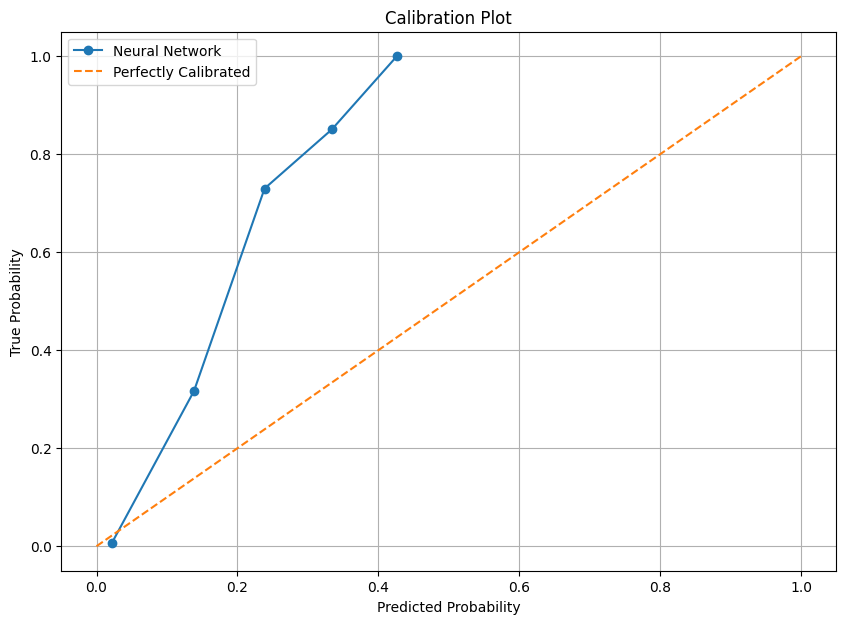

In [216]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# Calculate calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_pred_rf, n_bins=10)

# Plot calibration curve
plt.figure(figsize=(10, 7))
plt.plot(prob_pred, prob_true, marker='o', linestyle='-', label='Neural Network')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.title('Calibration Plot')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.legend()
plt.grid()
plt.savefig('rf_calibration_before.png')
plt.show()

(187112,)
(187112,)
True
[0.00481006 0.14341489 0.2611623  0.32815302 0.46189024 0.54234528
 0.64686099 0.75042735 0.86499215 0.94055482]


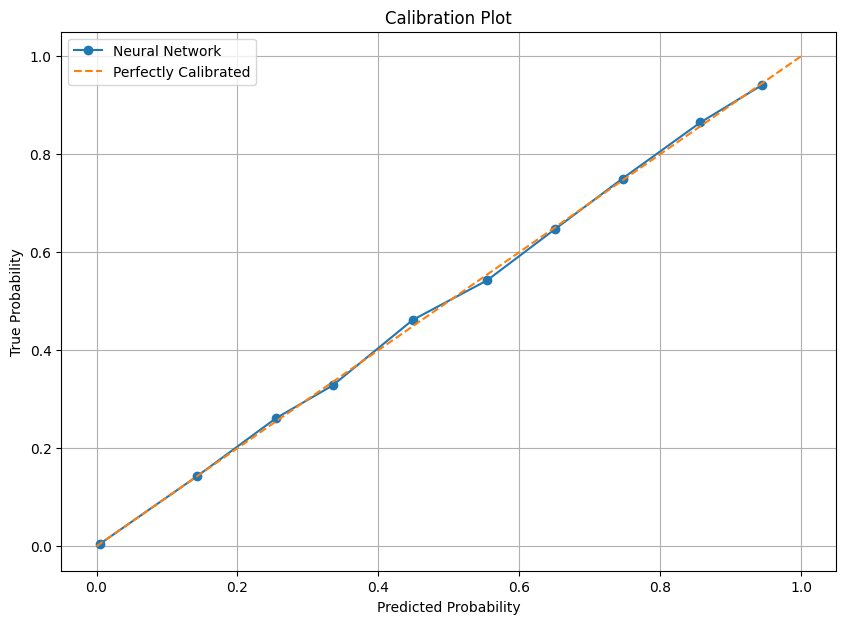

[0.00515712 0.14837398 0.25464191 0.37980769 0.46385542 0.52201258
 0.6284585  0.74305556 0.74045802 0.87412587]


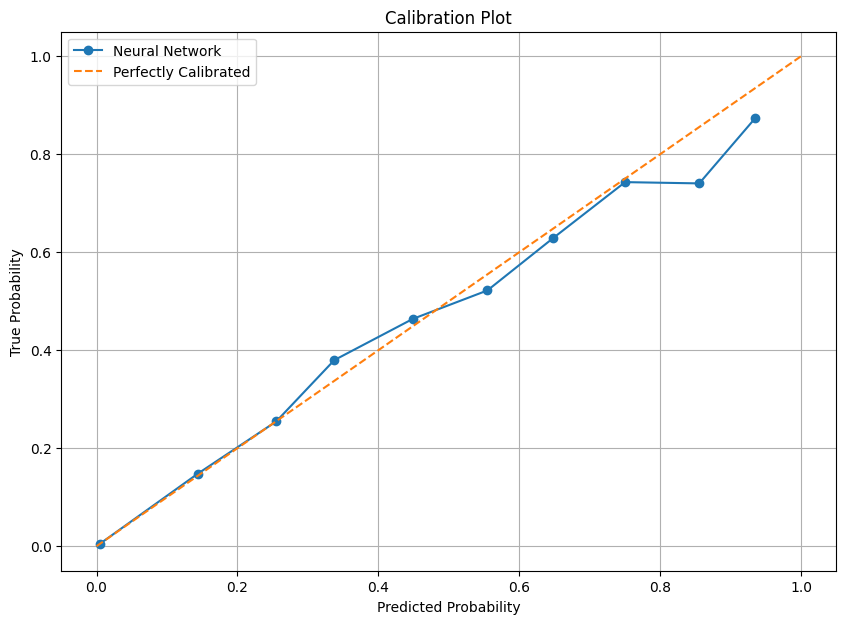

Ranndom Forest Model AUC: 0.974 (0.971, 0.977)
Ranndom Forest Model AUC: 0.974 (0.971, 0.977)


In [217]:
y_pred_rf_train = rf_bb.predict_proba(X_train_scaled)[:, 1]

print(y_train.shape)
print(y_pred_rf_train.shape)

# Create a DataFrame
data = pd.DataFrame({'outcome': y_train, 'score': y_pred_rf_train})

# Fit a Logistic GAM model
gam = LogisticGAM(s(0)).fit(data['score'], data['outcome'])
spnow = gam.lam

# Predict using the GAM model
y_pred_rf_train_calib = gam.predict_proba(data['score'])

print(is_monotonic(y_pred_rf_train_calib, y_train, n_bins=10))

if not is_monotonic(y_pred_rf_train_calib, y_train, n_bins=10):
    print("GAM not yet monotonic, tune!!!")
    # Tune smoothing parameter to achieve monotonicity
    tunes = np.logspace(-3, 3, 10)
    for tune in tunes:
        tune = float(tune)
        gam = LogisticGAM(s(0),lam=spnow[0][0]*tune).fit(data['score'], data['outcome'])
        y_pred_rf_train_calib = gam.predict_proba(data['score'])
        if is_monotonic(y_pred_rf_train_calib, y_train, n_bins=10):
            print(f"Monotonicity achieved with sp = {spnow[0][0] * tune}")
            break

# Use the final calibrated predictions
y_pred_rf_test_calib = gam.predict_proba(y_pred_rf)

# Calculate calibration curve
prob_true, prob_pred = calibration_curve(y_train, y_pred_rf_train_calib, n_bins=10)
print(prob_true)

# Plot calibration curve
plt.figure(figsize=(10, 7))
plt.plot(prob_pred, prob_true, marker='o', linestyle='-', label='Neural Network')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.title('Calibration Plot')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.legend()
plt.grid()
plt.show()

# Calculate calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_pred_rf_test_calib, n_bins=10)
print(prob_true)

# Plot calibration curve
plt.figure(figsize=(10, 7))
plt.plot(prob_pred, prob_true, marker='o', linestyle='-', label='Neural Network')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.title('Calibration Plot')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.legend()
plt.grid()
plt.savefig('rf_calibration_after.png')
plt.show()

# Calculate AUC
auc_ffn, ci_ffn = roc_auc_score(y_test,
                        y_pred_rf,
                        confidence_level=0.95)

print(f'Ranndom Forest Model AUC: {auc_ffn:.3f} ({ci_ffn[0]:.3f}, {ci_ffn[1]:.3f})')

# Calculate AUC
auc_ffn, ci_ffn = roc_auc_score(y_test,
                        y_pred_rf_test_calib,
                        confidence_level=0.95)

print(f'Ranndom Forest Model AUC: {auc_ffn:.3f} ({ci_ffn[0]:.3f}, {ci_ffn[1]:.3f})')


In [8]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [9]:
# Define the neural network model using nn.Sequential
class FeedForwardNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate, num_layers):
        super(FeedForwardNN, self).__init__()
        
        layers = []
        # Input layer
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.BatchNorm1d(hidden_dim))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_rate))
        
        # Hidden layers
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
        
        # Output layer
        layers.append(nn.Linear(hidden_dim, output_dim))
        layers.append(nn.Sigmoid())
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [21]:
# Hyperparameters
input_dim = X_train.shape[1]
hidden_dim = 256
output_dim = 1
dropout_rate = 0.5
learning_rate = 0.001
num_layers = 3  # Including the input layer
num_epochs = 30

# Initialize the model, loss function, and optimizer
model_nn_bb = FeedForwardNN(input_dim, hidden_dim, output_dim, dropout_rate, num_layers)#.to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model_nn_bb.parameters(), lr=learning_rate)

# Training the model
model_nn_bb.train()
for epoch in tqdm(range(num_epochs)):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model_nn_bb(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

  0%|          | 0/30 [00:00<?, ?it/s]

 33%|███▎      | 10/30 [08:25<16:51, 50.56s/it]

Epoch [10/30], Loss: 0.0401


 67%|██████▋   | 20/30 [16:51<08:26, 50.69s/it]

Epoch [20/30], Loss: 0.0720


100%|██████████| 30/30 [25:17<00:00, 50.58s/it]

Epoch [30/30], Loss: 0.0134


In [22]:
# Evaluating the model
# model_nn_bb.eval()
# with torch.no_grad():
#     y_pred_prob = model_nn_bb(X_test_tensor).numpy()

# y_pred_prob = y_pred_prob.reshape(-1)

# # Calculate AUC
# auc_ffn, ci_ffn = roc_auc_score(y_test,
#                         y_pred_prob,
#                         confidence_level=0.95)

# print(f'Neural Network Model AUC: {auc_ffn:.3f} ({ci_ffn[0]:.3f}, {ci_ffn[1]:.3f})')

# # Assume model_nn_bb is your PyTorch model
# torch.save(model_nn_bb.state_dict(), 'model_nn_bb.pth')
# print('model_saved')

Neural Network Model AUC: 0.955 (0.948, 0.962)
model_saved


In [12]:
# Hyperparameters
input_dim = X_train.shape[1]
hidden_dim = 256
output_dim = 1
dropout_rate = 0.5
learning_rate = 0.001
num_layers = 3  # Including the input layer
num_epochs = 30


model_nn_bb = FeedForwardNN(input_dim, hidden_dim, output_dim, dropout_rate, num_layers)
model_nn_bb.load_state_dict(torch.load('model_nn_bb.pth'))
model_nn_bb.eval()
with torch.no_grad():
    y_pred_prob_nn_bb = model_nn_bb(X_test_tensor).numpy()

y_pred_prob_nn_bb = y_pred_prob_nn_bb.reshape(-1)

# Calculate AUC
auc_ffn, ci_ffn = roc_auc_score(y_test,
                        y_pred_prob_nn_bb,
                        confidence_level=0.95)

print(f'Neural Network Model AUC: {auc_ffn:.3f} ({ci_ffn[0]:.3f}, {ci_ffn[1]:.3f})')

# Assume model_nn_bb is your PyTorch model
torch.save(model_nn_bb.state_dict(), 'model_nn_bb.pth')
print('model_saved')


Neural Network Model AUC: 0.955 (0.948, 0.962)
model_saved


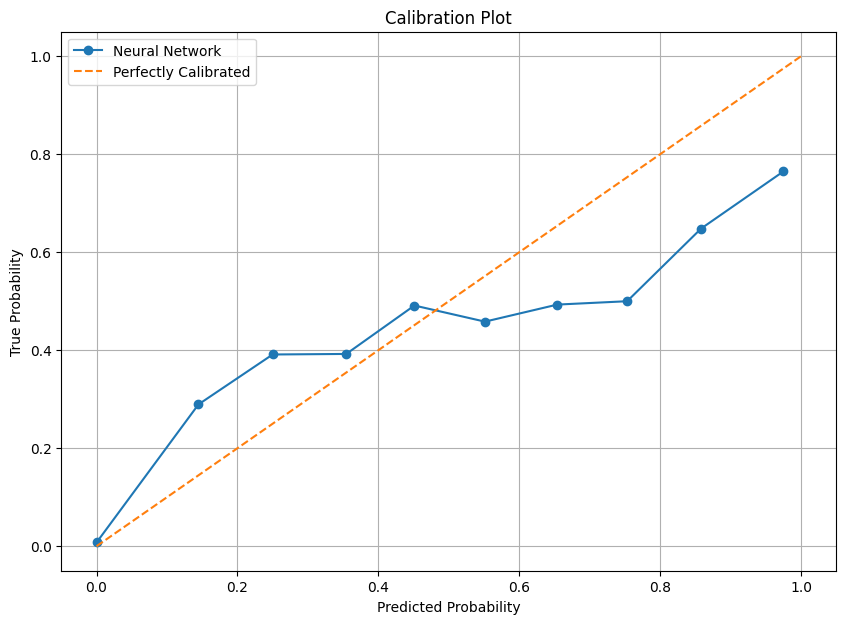

In [218]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# Assuming y_test_tensor and y_pred_prob_nn_bb are already defined
y_test_numpy = y_test_tensor.numpy().reshape(-1)  # Convert y_test_tensor to numpy array

# Calculate calibration curve
prob_true, prob_pred = calibration_curve(y_test_numpy, y_pred_prob_nn_bb, n_bins=10)

# Plot calibration curve
plt.figure(figsize=(10, 7))
plt.plot(prob_pred, prob_true, marker='o', linestyle='-', label='Neural Network')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.title('Calibration Plot')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.legend()
plt.grid()
plt.savefig('nn_calibration_before.png')
plt.show()

False
GAM not yet monotonic, tune!!!
Monotonicity achieved with sp = 0.27849533001676663
[1.21379980e-04 1.31386861e-01 2.50000000e-01 3.33333333e-01
 3.52941176e-01 5.62500000e-01 6.56250000e-01 7.50000000e-01
 8.53658537e-01 9.97016039e-01]


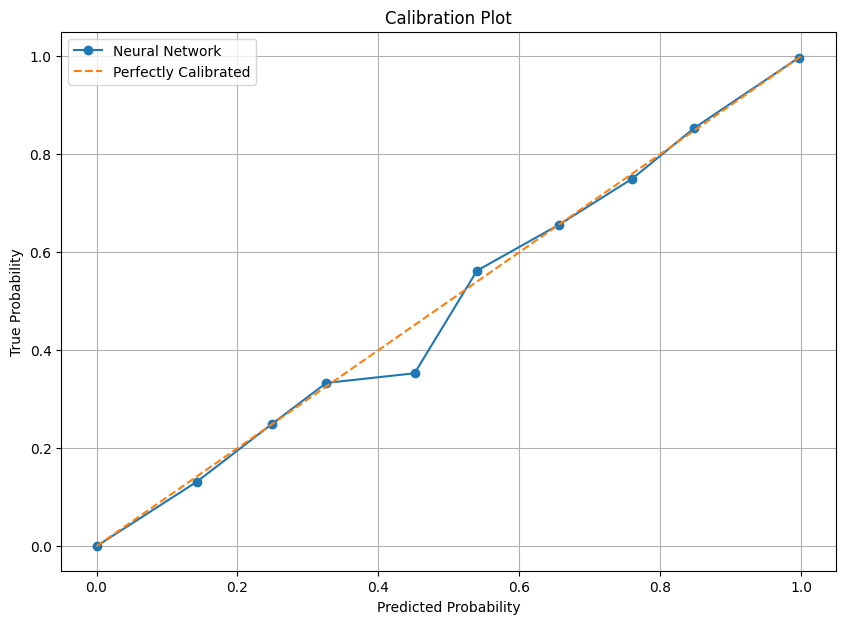

[0.00898111 0.30097087 0.43209877 0.31632653 0.42307692 0.42307692
 0.58823529 0.45882353 0.48275862 0.73490276]


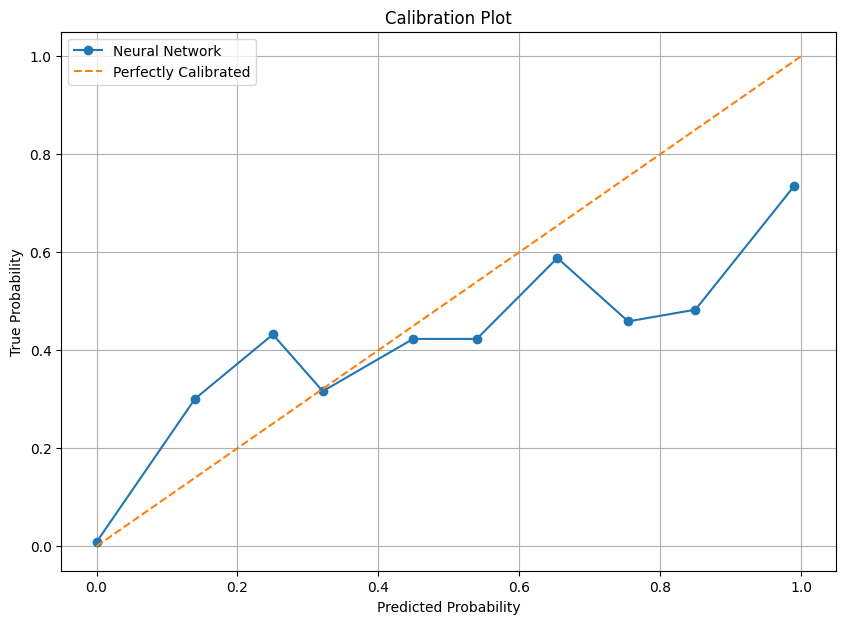

Neural Network Model AUC: 0.955 (0.948, 0.962)
Neural Network Model AUC: 0.955 (0.948, 0.962)


In [219]:
import numpy as np
import pandas as pd
from pygam import LogisticGAM, s

with torch.no_grad():
    y_pred_prob_nn_bb_train = model_nn_bb(X_train_tensor).numpy().reshape(-1)

# Assuming y_test_tensor and y_pred_prob_nn_bb are already defined
y_train_numpy = y_train_tensor.numpy().reshape(-1)  # Convert y_test_tensor to numpy array

# Create a DataFrame
data = pd.DataFrame({'outcome': y_train_numpy, 'score': y_pred_prob_nn_bb_train})

# Fit a Logistic GAM model
gam = LogisticGAM(s(0)).fit(data['score'], data['outcome'])
spnow = gam.lam

# Predict using the GAM model
y_pred_prob_nn_bb_calib_train = gam.predict_proba(data['score'])

print(is_monotonic(y_pred_prob_nn_bb_calib_train, y_train_numpy, n_bins=10))

if not is_monotonic(y_pred_prob_nn_bb_calib_train, y_train_numpy, n_bins=10):
    print("GAM not yet monotonic, tune!!!")
    # Tune smoothing parameter to achieve monotonicity
    tunes = np.logspace(-3, 3, 10)
    for tune in tunes:
        tune = float(tune)
        gam = LogisticGAM(s(0),lam=spnow[0][0]*tune).fit(data['score'], data['outcome'])
        y_pred_prob_nn_bb_calib_train = gam.predict_proba(data['score'])
        if is_monotonic(y_pred_prob_nn_bb_calib_train, y_train_numpy, n_bins=10):
            print(f"Monotonicity achieved with sp = {spnow[0][0] * tune}")
            break

# Use the final calibrated predictions
y_pred_prob_nn_bb_calib_test = gam.predict_proba(y_pred_prob_nn_bb)

# Calculate calibration curve
prob_true, prob_pred = calibration_curve(y_train_numpy, y_pred_prob_nn_bb_calib_train, n_bins=10)
print(prob_true)

# Plot calibration curve
plt.figure(figsize=(10, 7))
plt.plot(prob_pred, prob_true, marker='o', linestyle='-', label='Neural Network')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.title('Calibration Plot')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.legend()
plt.grid()
plt.show()

# Calculate calibration curve
prob_true, prob_pred = calibration_curve(y_test_numpy, y_pred_prob_nn_bb_calib_test, n_bins=10)
print(prob_true)

# Plot calibration curve
plt.figure(figsize=(10, 7))
plt.plot(prob_pred, prob_true, marker='o', linestyle='-', label='Neural Network')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.title('Calibration Plot')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.legend()
plt.grid()
plt.savefig('nn_calibration_after.png')
plt.show()

# Calculate AUC
auc_ffn, ci_ffn = roc_auc_score(y_test,
                        y_pred_prob_nn_bb,
                        confidence_level=0.95)

print(f'Neural Network Model AUC: {auc_ffn:.3f} ({ci_ffn[0]:.3f}, {ci_ffn[1]:.3f})')

# Calculate AUC
auc_ffn, ci_ffn = roc_auc_score(y_test,
                        y_pred_prob_nn_bb_calib_test,
                        confidence_level=0.95)

print(f'Neural Network Model AUC: {auc_ffn:.3f} ({ci_ffn[0]:.3f}, {ci_ffn[1]:.3f})')


#### Takeaway

All 3 model classes are able to produce accurate predictions on the MIMIC-IV dataset. 

Using GAMs as a non-linear transformation of the risk score to obtain better calibrated test-set predictions can help but is nor guaranteed to help.

### Step 2: Train mimic Model

#### Step 2.1: Evaluate the model fit (Can we )

Can we train a mimic model that fits the predictions of the black-box model well, even if 

In [187]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

################################################################################################################
# using xgb.XGBRegressor instead of xgb.XGBClassifier because the output of the black box model is continuous  #
# using LinearRegression instead of LogisticRegression because the output of the black box model is continuous #
################################################################################################################


def mimic_model_predict(X_train, X_test, bb_yhat, mimic_type, normalize=False):
    if mimic_type == 'lr':
        mimic_model = LinearRegression()
    elif mimic_type == 'xgb':
        mimic_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
    elif mimic_type == 'rf':
        mimic_model = RandomForestRegressor(max_depth=10,random_state=42)
    elif mimic_type == 'lasso':
        mimic_model = Lasso(alpha=0.001, random_state=42)
    mimic_model.fit(X_train, bb_yhat)
    yhat_mimic = mimic_model.predict(X_test)

    #Normalize between 0 and 1
    if normalize:
        yhat_mimic = (yhat_mimic - yhat_mimic.min()) / (yhat_mimic.max() - yhat_mimic.min())

    return yhat_mimic

def evaluate_mimic_model(X_train, X_test, bb_yhat, bb_type, mimic_type, y_test, y_hat_bb_test, normalize=False):
    yhat_mimic = mimic_model_predict(X_train, X_test, bb_yhat, mimic_type, normalize)
    auc, ci = roc_auc_score(y_test, 
                        yhat_mimic,
                        confidence_level=0.95)

    # print(y_hat_bb_test[:10])
    # print(yhat_mimic[:10])

    # print(y_hat_bb_test.max())
    # print(y_hat_bb_test.min())

    # print(yhat_mimic.min())
    # print(yhat_mimic.max())

    # print(diff_2.max())
    # print(diff_2.min())

    diff_2 = (y_hat_bb_test - yhat_mimic)**2
    rmse = np.sqrt(mean_squared_error(y_hat_bb_test, yhat_mimic))

    print(f'AUC of {bb_type} bb and {mimic_type} mimic model:  {auc:.3f} ({ci[0]:.3f}, {ci[1]:.3f})')
    print(f'RMSE between {bb_type} black box prediction and {mimic_type} mimic model prediction: {rmse:.4f}')
    return auc, rmse


In [91]:
# y_pred_lr_test_calib
# y_pred_lr_train_calib
# y_pred_rf_test_calib
# y_pred_rf_train_calib
# y_pred_prob_nn_bb_calib_train
# y_pred_prob_nn_bb_calib_test

# grid: bb types: lr, xgb, nn; mimic types: lr, xgb
auc_lr_lr, rmse_lr_lr = evaluate_mimic_model(X_train_scaled, X_test_scaled, y_pred_lr_train_calib, 'lr', 'lr', y_test, y_pred_lr_test_calib)
auc_lr_xgb, rmse_lr_xgb = evaluate_mimic_model(X_train_scaled, X_test_scaled, y_pred_lr_train_calib, 'lr', 'rf', y_test, y_pred_lr_test_calib)
auc_xgb_lr, rmse_xgb_lr = evaluate_mimic_model(X_train_scaled, X_test_scaled, y_pred_rf_train_calib, 'rf', 'lr', y_test, y_pred_rf_test_calib)
auc_xgb_xgb, rmse_xgb_xgb = evaluate_mimic_model(X_train_scaled, X_test_scaled, y_pred_rf_train_calib, 'rf', 'rf', y_test, y_pred_rf_test_calib)
auc_nn_lr, rmse_nn_lr = evaluate_mimic_model(X_train_scaled, X_test_scaled, y_pred_prob_nn_bb_calib_train, 'nn', 'lr', y_test, y_pred_prob_nn_bb_calib_test)
auc_nn_xgb, rmse_nn_xgb = evaluate_mimic_model(X_train_scaled, X_test_scaled, y_pred_prob_nn_bb_calib_train, 'nn', 'rf', y_test, y_pred_prob_nn_bb_calib_test)

AUC of lr bb and lr mimic model:  0.972 (0.967, 0.977)
RMSE between lr black box prediction and lr mimic model prediction: 136073590153.0465
AUC of lr bb and rf mimic model:  0.962 (0.956, 0.968)
RMSE between lr black box prediction and rf mimic model prediction: 0.0705
AUC of rf bb and lr mimic model:  0.966 (0.961, 0.971)
RMSE between rf black box prediction and lr mimic model prediction: 60846340745.5461
AUC of rf bb and rf mimic model:  0.946 (0.939, 0.953)
RMSE between rf black box prediction and rf mimic model prediction: 0.0303
AUC of nn bb and lr mimic model:  0.971 (0.966, 0.976)
RMSE between nn black box prediction and lr mimic model prediction: 78271757554.2807
AUC of nn bb and rf mimic model:  0.964 (0.958, 0.969)
RMSE between nn black box prediction and rf mimic model prediction: 0.0957


In [188]:
auc_lr_lr, rmse_lr_lr = evaluate_mimic_model(X_train_scaled, X_test_scaled, y_pred_lr_train_calib, 'lr', 'lasso', y_test, y_pred_lr_test_calib)
auc_xgb_lr, rmse_xgb_lr = evaluate_mimic_model(X_train_scaled, X_test_scaled, y_pred_rf_train_calib, 'rf', 'lasso', y_test, y_pred_rf_test_calib)
auc_nn_lr, rmse_nn_lr = evaluate_mimic_model(X_train_scaled, X_test_scaled, y_pred_prob_nn_bb_calib_train, 'nn', 'lasso', y_test, y_pred_prob_nn_bb_calib_test)

AUC of lr bb and lasso mimic model:  0.974 (0.970, 0.978)
RMSE between lr black box prediction and lasso mimic model prediction: 0.0776
AUC of rf bb and lasso mimic model:  0.968 (0.964, 0.972)
RMSE between rf black box prediction and lasso mimic model prediction: 0.0433
AUC of nn bb and lasso mimic model:  0.974 (0.970, 0.978)
RMSE between nn black box prediction and lasso mimic model prediction: 0.1059


#### Takeaway
For the tabular data based models compared here, distillation appears to be able to preserve the performance of risk scores produced using different model classes. One caveat to this analysis is that the performance differences between linear and non-linear methods on these datasets are marginal.

### Step 3: Compare feature importances 
Are we able to recover robust feature importances using a MIMIC model of different model classes.

Issue in paper --> they don't have groundtruth and use outcome model which may not be useful if the true goal is interpretability.

Hence, we wonder do the most positive and most negative features match between the black-box models and the mimic models.

If this works, we do some qualitative assessment for mimic model that evaluates the neural network model features.

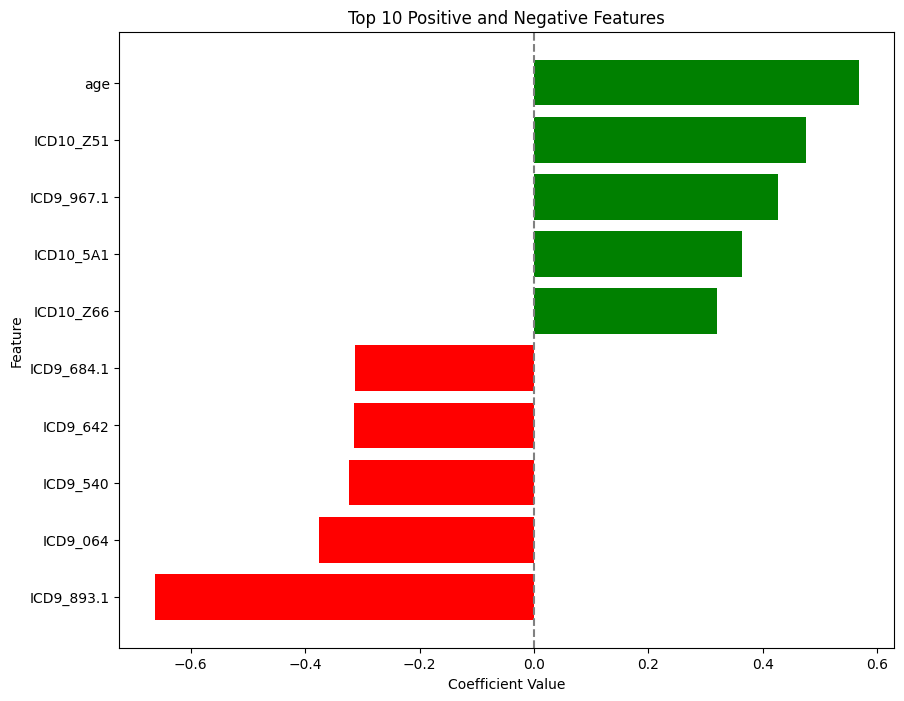

In [198]:
# Extracting coefficients
coefficients = log_reg_bb.coef_[0]
feature_names_real = X_train.columns

# Creating a dataframe for coefficients and feature names
coef_df = pd.DataFrame({
    'Feature': feature_names_real,
    'Coefficient': coefficients
})

# Sorting by absolute value of the coefficients
coef_df['abs_coef'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Coefficient', ascending=True)

# Getting the top 10 positive and top 10 negative features
top_features = pd.concat([coef_df.head(5),coef_df.tail(5)])

top_features_name = top_features['Feature']

# Plotting the coefficients
plt.figure(figsize=(10, 8))
plt.barh(top_features['Feature'], top_features['Coefficient'], color=np.where(top_features['Coefficient'] > 0, 'g', 'r'))
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Top 10 Positive and Negative Features')
plt.axvline(x=0, color='grey', linestyle='--')
plt.show()

In [117]:
######################################################################################
######################################################################################
######################################################################################

mimic_model_lr_for_lrbb = LinearRegression()
# print(X_train_scaled.shape)
# print(y_pred_lr_train_calib.shape)

# Assuming X_train_scaled and y_pred_lr_train_calib are NumPy arrays
X_train_scaled_df = pd.DataFrame(X_train_scaled)
y_pred_lr_train_calib_df = pd.Series(y_pred_lr_train_calib)

# print(X_train_scaled_df.describe())
# print(y_pred_lr_train_calib_df.describe())
mimic_model_lr_for_lrbb.fit(X_train_scaled, y_pred_lr_train_calib)

LinearRegression()

103172542391.13414
-69009072168.60507
        Feature   Coefficient
1387  ICD10_V74 -6.900907e+10


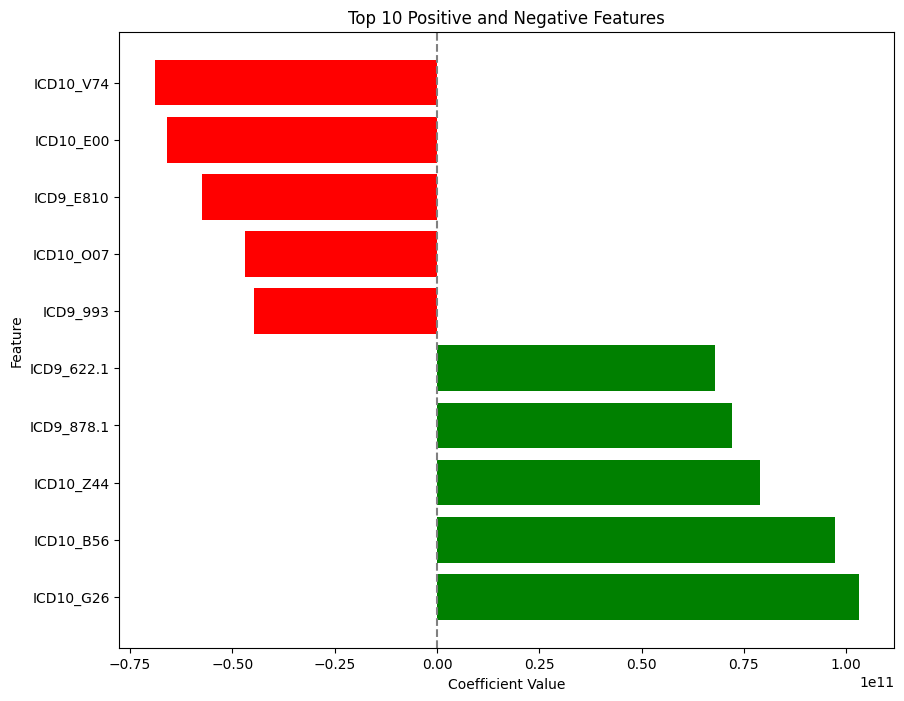

432     1.031725e+11
89      9.723376e+10
1552    7.903411e+10
4007    7.200482e+10
3784    6.788084e+10
2465   -4.461241e+10
965    -4.680628e+10
2495   -5.736722e+10
283    -6.606157e+10
1387   -6.900907e+10
Name: Coefficient, dtype: float64


In [143]:
# Extracting coefficients
coefficients = mimic_model_lr_for_lrbb.coef_
print(coefficients.max())
print(coefficients.min())

feature_names = X_train.columns

# Creating a dataframe for coefficients and feature names
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

print(coef_df[coef_df['Feature']=='ICD10_V74'])

# Sorting by absolute value of the coefficients
coef_df['abs_coef'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

# Getting the top 10 positive and top 10 negative features
top_features = pd.concat([coef_df.head(5), coef_df.tail(5)])

# Plotting the coefficients
plt.figure(figsize=(10, 8))
plt.barh(top_features['Feature'], top_features['Coefficient'], color=np.where(top_features['Coefficient'] > 0, 'g', 'r'))
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Top 10 Positive and Negative Features')
plt.axvline(x=0, color='grey', linestyle='--')
plt.show()

print(top_features['Coefficient'])

In [144]:
# Check quantile of real top 10 features
from scipy.stats import percentileofscore

percentiles = []
feat_values = []
for feature in top_features_name:
    coef_value = coef_df[coef_df['Feature']==feature]['Coefficient'].item()
    print(coef_value)
    feat_values.append(coef_value)
    percentile = percentileofscore(coef_df['Coefficient'], coef_value)
    percentiles.append(percentile)
    
    
coef_perc_df = pd.DataFrame({
    'Feature': top_features_name[::-1],
    'coefficient': feat_values[::-1],
    'Percentile': percentiles[::-1]
})

display(coef_perc_df)

0.0012390613555908203
0.0003762245178222656
-0.0002256631851196289
-6.070733070373535e-05
-0.00014007091522216797
0.021826624870300293
0.012865304946899414
0.029382407665252686
0.03728675842285156
0.005557821011625158


,Feature,coefficient,Percentile
0,age,0.005558,98.076923
1558,ICD10_Z51,0.037287,98.563778
4050,ICD9_967.1,0.029382,98.515093
3227,ICD10_5A1,0.012865,98.442064
1569,ICD10_Z66,0.021827,98.490750
3834,ICD9_684.1,-0.000140,34.664070
2150,ICD9_642,-0.000061,43.646543
2061,ICD9_540,-0.000226,27.288218
3374,ICD9_064,0.000376,84.956183
4020,ICD9_893.1,0.001239,95.155794


### Lasso mimic?

In [152]:
# Fit the LASSO model
lasso_model = Lasso(alpha=0.001, random_state=42)  # Adjust alpha as needed
lasso_model.fit(X_train_scaled, y_pred_lr_train_calib)

Lasso(alpha=0.001, random_state=42)

[ 2.11641635e-03 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -2.76928043e-05 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00]


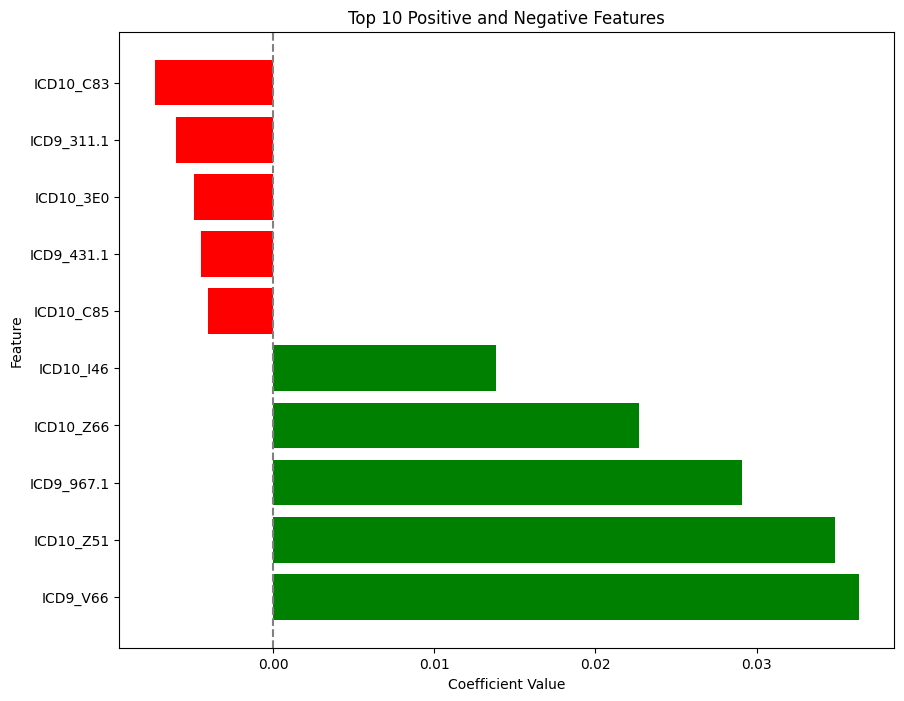

2688    0.036361
1558    0.034881
4050    0.029105
1569    0.022720
574     0.013847
190    -0.004014
3618   -0.004484
3221   -0.004920
3521   -0.006027
188    -0.007345
Name: Coefficient, dtype: float64
         Feature  Coefficient  abs_coef
2688    ICD9_V66     0.036361  0.036361
1558   ICD10_Z51     0.034881  0.034881
4050  ICD9_967.1     0.029105  0.029105
1569   ICD10_Z66     0.022720  0.022720
574    ICD10_I46     0.013847  0.013847


In [156]:
# Extract coefficients
coefficients = lasso_model.coef_
feature_names = X_train.columns

print(coefficients[:10])

# Creating a dataframe for coefficients and feature names
coef_df_lasso = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sorting by absolute value of the coefficients
coef_df_lasso['abs_coef'] = coef_df_lasso['Coefficient'].abs()
coef_df_lasso = coef_df_lasso.sort_values(by='Coefficient', ascending=False)

# Getting the top 10 positive and top 10 negative features
top_features_lasso = pd.concat([coef_df_lasso.head(5), coef_df_lasso.tail(5)])

# Plotting the coefficients
plt.figure(figsize=(10, 8))
plt.barh(top_features_lasso['Feature'], top_features_lasso['Coefficient'], color=np.where(top_features_lasso['Coefficient'] > 0, 'g', 'r'))
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Top 10 Positive and Negative Features')
plt.axvline(x=0, color='grey', linestyle='--')
plt.show()

print(top_features_lasso['Coefficient'])

print(coef_df_lasso.head(5))

In [157]:
percentiles = []
feat_values = []
for feature in top_features_name:
    coef_value = coef_df_lasso[coef_df_lasso['Feature']==feature]['Coefficient'].item()
    feat_values.append(coef_value)
    percentile = percentileofscore(coef_df_lasso['Coefficient'], coef_value)
    percentiles.append(percentile)
    
    
coef_perc_df_lasso = pd.DataFrame({
    'Feature': top_features_name[::-1],
    'coefficient': feat_values[::-1],
    'Percentile': percentiles[::-1]
})

display(coef_perc_df_lasso)

,Feature,coefficient,Percentile
0,age,0.002116,99.099318
1558,ICD10_Z51,0.034881,99.975657
4050,ICD9_967.1,0.029105,99.951315
3227,ICD10_5A1,0.007977,99.756573
1569,ICD10_Z66,0.022720,99.926972
3834,ICD9_684.1,-0.000000,50.279942
2150,ICD9_642,0.000000,50.279942
2061,ICD9_540,0.000000,50.279942
3374,ICD9_064,0.000000,50.279942
4020,ICD9_893.1,0.000000,50.279942


##### Random forest black box model

0.0
0.07332145581626234


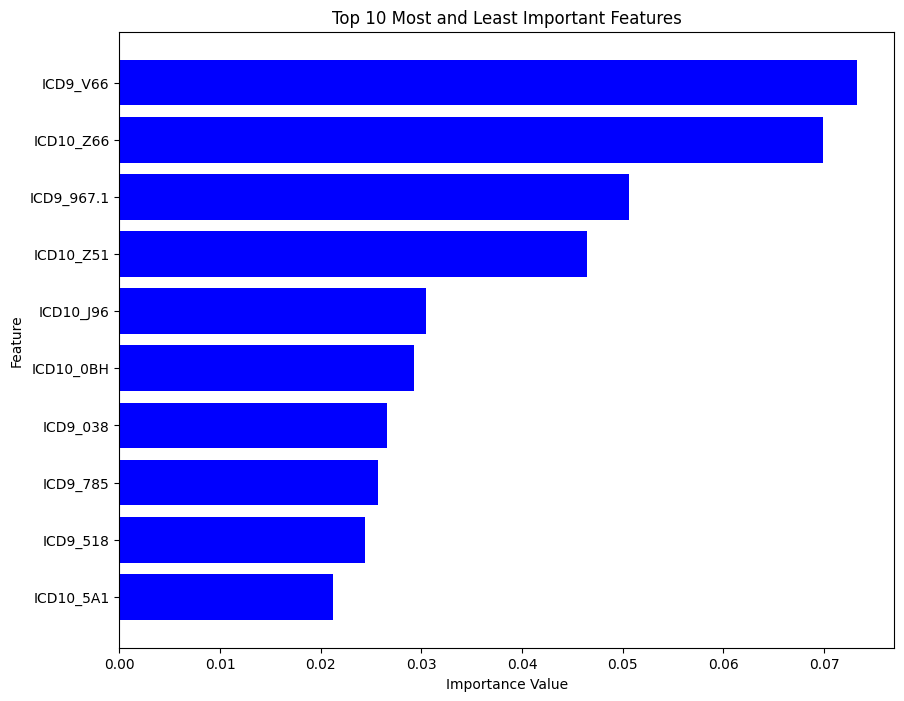

Random Forest Model AUC (in distribution): 0.974
3227    0.021198
2039    0.024444
2274    0.025702
1629    0.026560
2878    0.029311
669     0.030480
1558    0.046443
4050    0.050610
1569    0.069914
2688    0.073321
Name: Importance, dtype: float64


In [210]:
# Extract feature importances
importances = rf_bb.feature_importances_

print(importances.min())
print(importances.max())

feature_names = X_train.columns

# Creating a dataframe for importances and feature names
importance_df_rf = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sorting by importance
importance_df_rf = importance_df_rf.sort_values(by='Importance', ascending=True)

# Getting the top 10 most important and top 10 least important features
top_features_rf = pd.concat([importance_df_rf.tail(10)])

top_features_name_rf = top_features_rf['Feature']

# Plotting the importances
plt.figure(figsize=(10, 8))
plt.barh(top_features_rf['Feature'], top_features_rf['Importance'], color='b')
plt.xlabel('Importance Value')
plt.ylabel('Feature')
plt.title('Top 10 Most and Least Important Features')
plt.show()

print(f'Random Forest Model AUC (in distribution): {auc_rf:.3f}')

print(top_features_rf['Importance'])

In [161]:
######################################################################################
######################################################################################
######################################################################################

mimic_model_lr_for_rfbb = LinearRegression()

X_train_scaled_df = pd.DataFrame(X_train_scaled)
y_pred_rf_train_calib_df = pd.Series(y_pred_rf_train_calib)

# Fit model
mimic_model_lr_for_rfbb.fit(X_train_scaled_df, y_pred_rf_train_calib_df)

LinearRegression()

54455993962.14012
-80573705885.22581


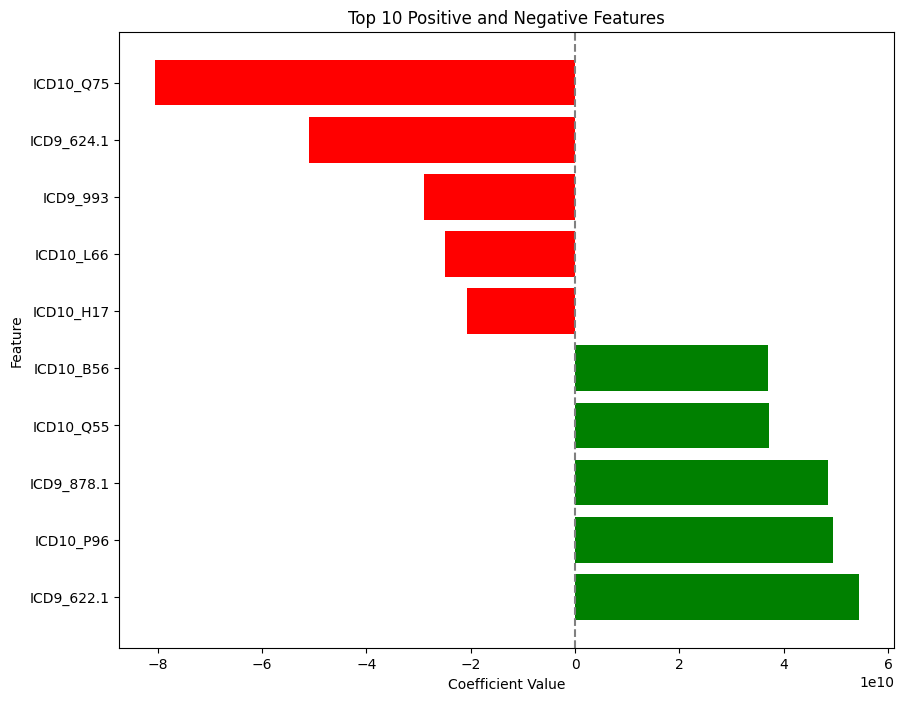

3784    5.445599e+10
1033    4.950489e+10
4007    4.853234e+10
1072    3.713281e+10
89      3.692456e+10
487    -2.064748e+10
780    -2.486798e+10
2465   -2.891862e+10
3786   -5.091607e+10
1085   -8.057371e+10
Name: Coefficient, dtype: float64


In [167]:
# Extracting coefficients
coefficients = mimic_model_lr_for_rfbb.coef_
print(coefficients.max())
print(coefficients.min())
feature_names = X_train.columns

# Creating a dataframe for coefficients and feature names
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sorting by absolute value of the coefficients
coef_df['abs_coef'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

# Getting the top 10 positive and top 10 negative features
top_features = pd.concat([coef_df.head(5), coef_df.tail(5)])

# Plotting the coefficients
plt.figure(figsize=(10, 8))
plt.barh(top_features['Feature'], top_features['Coefficient'], color=np.where(top_features['Coefficient'] > 0, 'g', 'r'))
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Top 10 Positive and Negative Features')
plt.axvline(x=0, color='grey', linestyle='--')
plt.show()

print(top_features['Coefficient'])

In [173]:
percentiles = []
feat_values = []
for feature in top_features_name_rf:
    coef_value = coef_df[coef_df['Feature']==feature]['Coefficient'].item()
    feat_values.append(coef_value)
    percentile = percentileofscore(coef_df['Coefficient'], coef_value)
    percentiles.append(percentile)
    
    
coef_perc_df_rf_lr = pd.DataFrame({
    'Feature': top_features_name[::-1],
    'coefficient': feat_values[::-1],
    'Percentile': percentiles[::-1]
})

display(coef_perc_df_rf_lr)

,Feature,coefficient,Percentile
0,age,0.029662,98.393379
1558,ICD10_Z51,0.023370,98.369036
4050,ICD9_967.1,0.017336,98.320351
3227,ICD10_5A1,0.019479,98.344693
1569,ICD10_Z66,0.010874,98.198637
3834,ICD9_684.1,0.014598,98.296008
2150,ICD9_642,0.011582,98.222980
2061,ICD9_540,0.010406,98.174294
3374,ICD9_064,0.006041,97.955209
4020,ICD9_893.1,0.008271,98.101266


#### LASSO mimic model

In [178]:
######################################################################################
######################################################################################
######################################################################################

# Fit the LASSO model
lasso_model_rf = Lasso(alpha=0.001, random_state=42)  # Adjust alpha as needed
lasso_model_rf.fit(X_train_scaled_df, y_pred_rf_train_calib_df)

Lasso(alpha=0.001, random_state=42)

[-0. -0. -0. -0. -0. -0. -0. -0. -0.  0.]


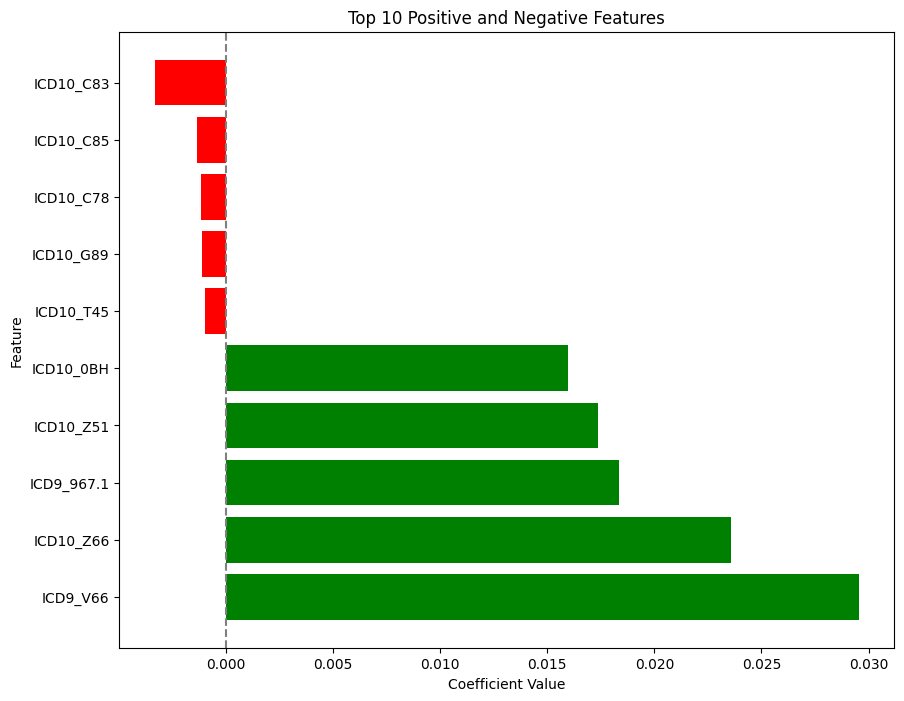

2688      ICD9_V66
1569     ICD10_Z66
4050    ICD9_967.1
1558     ICD10_Z51
2878     ICD10_0BH
1309     ICD10_T45
467      ICD10_G89
181      ICD10_C78
190      ICD10_C85
188      ICD10_C83
Name: Feature, dtype: object
2688    0.029563
1569    0.023591
4050    0.018338
1558    0.017350
2878    0.015986
1309   -0.000962
467    -0.001113
181    -0.001166
190    -0.001337
188    -0.003332
Name: Coefficient, dtype: float64


In [183]:
# Extract coefficients
coefficients = lasso_model_rf.coef_
feature_names = X_train.columns

print(coefficients[:10])

# Creating a dataframe for coefficients and feature names
coef_df_lasso_rf = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sorting by absolute value of the coefficients
coef_df_lasso_rf['abs_coef'] = coef_df_lasso_rf['Coefficient'].abs()
coef_df_lasso_rf = coef_df_lasso_rf.sort_values(by='Coefficient', ascending=False)

# Getting the top 10 positive and top 10 negative features
top_features_lasso_rf = pd.concat([coef_df_lasso_rf.head(5), coef_df_lasso_rf.tail(5)])

# Plotting the coefficients
plt.figure(figsize=(10, 8))
plt.barh(top_features_lasso_rf['Feature'], top_features_lasso_rf['Coefficient'], color=np.where(top_features_lasso_rf['Coefficient'] > 0, 'g', 'r'))
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Top 10 Positive and Negative Features')
plt.axvline(x=0, color='grey', linestyle='--')
plt.show()

print(top_features_lasso_rf['Feature'])
print(top_features_lasso_rf['Coefficient'])


In [185]:
percentiles = []
feat_values = []
for feature in top_features_name_rf:
    coef_value = coef_df_lasso_rf[coef_df_lasso_rf['Feature']==feature]['Coefficient'].item()
    feat_values.append(coef_value)
    percentile = percentileofscore(coef_df_lasso_rf['Coefficient'], coef_value)
    percentiles.append(percentile)
    
    
coef_perc_df_rf_lasso = pd.DataFrame({
    'Feature': top_features_name_rf[::-1],
    'coefficient': feat_values[::-1],
    'Percentile': percentiles[::-1]
})

display(coef_perc_df_rf_lasso)

,Feature,coefficient,Percentile
2688,ICD9_V66,0.029563,100.000000
1569,ICD10_Z66,0.023591,99.975657
4050,ICD9_967.1,0.018338,99.951315
1558,ICD10_Z51,0.017350,99.926972
669,ICD10_J96,0.011760,99.829601
2878,ICD10_0BH,0.015986,99.902629
1629,ICD9_038,0.011625,99.805258
2274,ICD9_785,0.010437,99.732230
2039,ICD9_518,0.005715,99.610516
3227,ICD10_5A1,0.004937,99.537488


### Ablation: Assess if missing features imply correlation in mimic and outcome model 

Do the claims: 
- (1) Distillation is possible
- (2) Feature importances of mimic model are indicative of real model feature importances

Experiment 1: Drop 2 key features from data (i.e. median impute)

Do we still attain similar predictive performance of the distilled model?
Do the feature importances stay the same? 

In [190]:
# create dataset with missing features
X_train_missing = X_train.copy()
X_train_missing['age']=X_train['age'].median()
X_train_missing['ICD9_V66']=0

X_test_missing = X_test.copy()
X_test_missing['age']=X_train['age'].median()
X_test_missing['ICD9_V66']=0

# # Standardize the features for LASSO
scaler = StandardScaler()
X_train_missing_scaled = scaler.fit_transform(X_train_missing)
X_test_missing_scaled = scaler.transform(X_test_missing)

(187112,)
(187112,)
True
[0.00396848 0.13377309 0.26687435 0.33381192 0.4605087  0.54815574
 0.65819861 0.73616019 0.85885886 0.94609665]


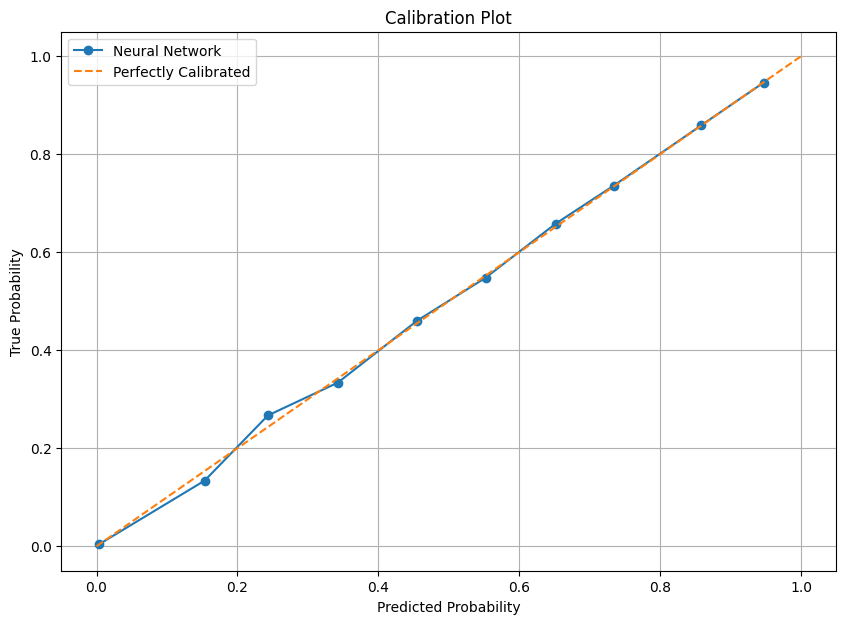

[0.00706834 0.13849093 0.26415094 0.32024169 0.42580645 0.51054852
 0.54455446 0.64606742 0.67099567 0.82986111]


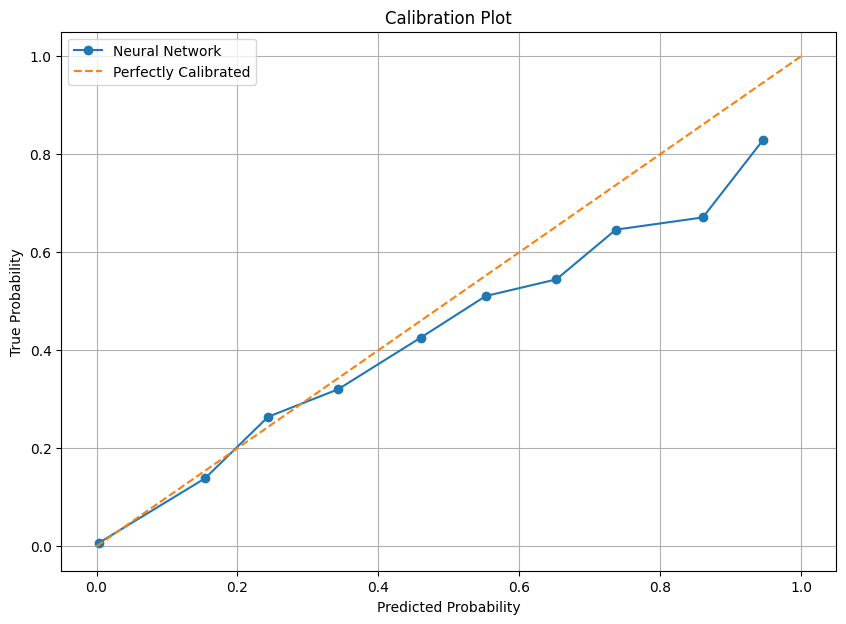

Logistic Regression Model AUC: 0.943 (0.935, 0.951)
Logistic Regression Model AUC: 0.943 (0.935, 0.951)


In [191]:
#######################################################################
######## Get black box preds

y_pred_lr_test_missing = log_reg_bb.predict_proba(X_test_missing_scaled)[:, 1]
y_pred_lr_train_missing = log_reg_bb.predict_proba(X_train_missing_scaled)[:, 1]

print(y_train.shape)
print(y_pred_lr_train_missing.shape)

# Create a DataFrame
data = pd.DataFrame({'outcome': y_train, 'score': y_pred_lr_train_missing})

# Fit a Logistic GAM model
gam = LogisticGAM(s(0)).fit(data['score'], data['outcome'])
spnow = gam.lam

# Predict using the GAM model
y_pred_lr_train_calib_missing = gam.predict_proba(data['score'])

print(is_monotonic(y_pred_lr_train_calib_missing, y_train, n_bins=10))

if not is_monotonic(y_pred_lr_train_calib_missing, y_train, n_bins=10):
    print("GAM not yet monotonic, tune!!!")
    # Tune smoothing parameter to achieve monotonicity
    tunes = np.logspace(-3, 3, 10)
    for tune in tunes:
        tune = float(tune)
        gam = LogisticGAM(s(0),lam=spnow[0][0]*tune).fit(data['score'], data['outcome'])
        y_pred_lr_train_calib_missing = gam.predict_proba(data['score'])
        if is_monotonic(y_pred_lr_train_calib_missing, y_train, n_bins=10):
            print(f"Monotonicity achieved with sp = {spnow[0][0] * tune}")
            break

# Use the final calibrated predictions
y_pred_lr_test_calib_missing = gam.predict_proba(y_pred_lr_test_missing)

# Calculate calibration curve
prob_true, prob_pred = calibration_curve(y_train, y_pred_lr_train_calib_missing, n_bins=10)
print(prob_true)

# Plot calibration curve
plt.figure(figsize=(10, 7))
plt.plot(prob_pred, prob_true, marker='o', linestyle='-', label='Neural Network')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.title('Calibration Plot')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.legend()
plt.grid()
plt.show()

# Calculate calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_pred_lr_test_calib_missing, n_bins=10)
print(prob_true)

# Plot calibration curve
plt.figure(figsize=(10, 7))
plt.plot(prob_pred, prob_true, marker='o', linestyle='-', label='Neural Network')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.title('Calibration Plot')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.legend()
plt.grid()
plt.show()

# Calculate AUC
auc_ffn, ci_ffn = roc_auc_score(y_test,
                        y_pred_lr_test_missing,
                        confidence_level=0.95)

print(f'Logistic Regression Model AUC: {auc_ffn:.3f} ({ci_ffn[0]:.3f}, {ci_ffn[1]:.3f})')

# Calculate AUC
auc_ffn, ci_ffn = roc_auc_score(y_test,
                        y_pred_lr_test_calib_missing,
                        confidence_level=0.95)

print(f'Logistic Regression Model AUC: {auc_ffn:.3f} ({ci_ffn[0]:.3f}, {ci_ffn[1]:.3f})')


True
[0.00570939 0.14060032 0.25704225 0.32528534 0.46964856 0.55703422
 0.64718163 0.71801567 0.87344913 0.94479495]


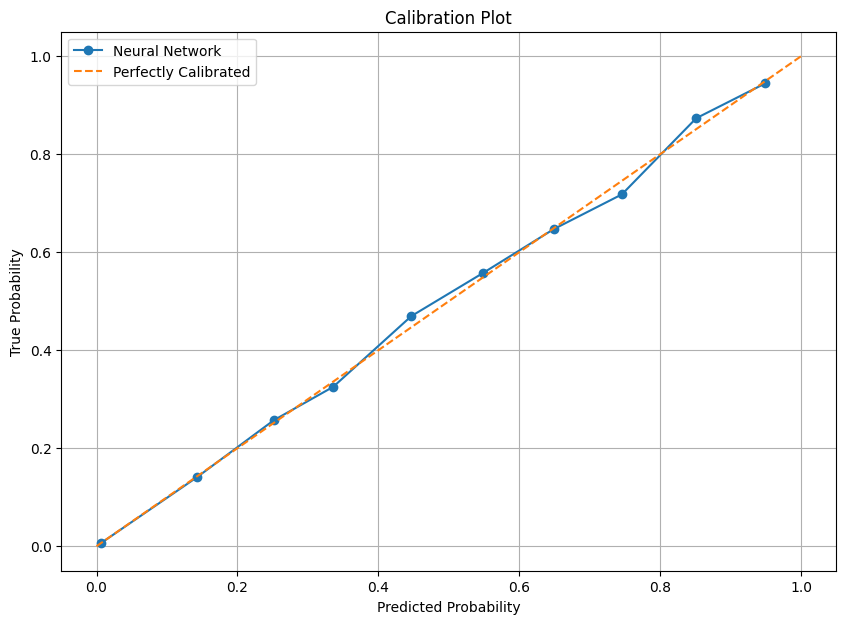

[0.00605893 0.15646853 0.23886139 0.35951134 0.50310559 0.43382353
 0.59839357 0.78095238 0.71428571 0.85714286]


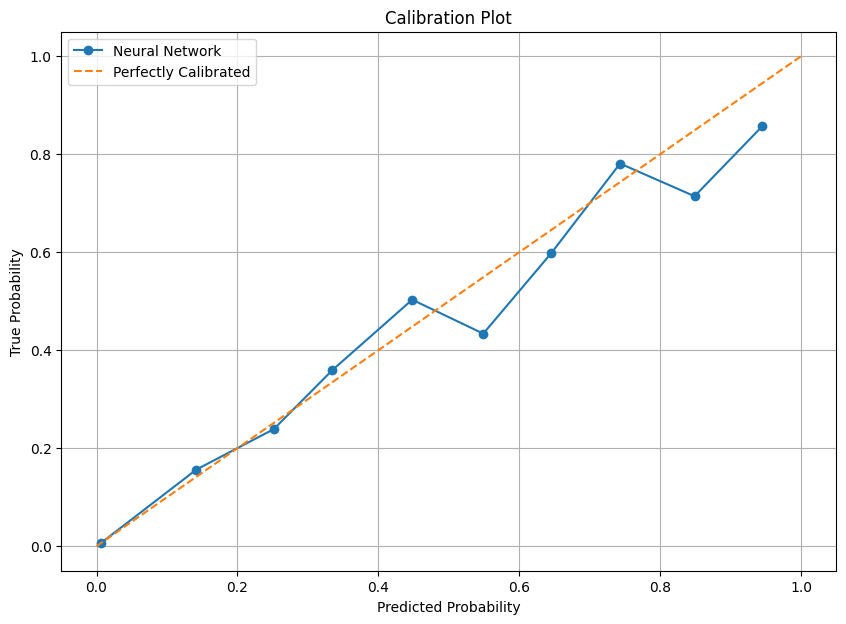

Logistic Regression Model AUC: 0.967 (0.964, 0.971)
Logistic Regression Model AUC: 0.967 (0.964, 0.971)


In [192]:
y_pred_rf_test_missing = rf_bb.predict_proba(X_test_missing_scaled)[:, 1]
y_pred_rf_train_missing = rf_bb.predict_proba(X_train_missing_scaled)[:, 1]

# Create a DataFrame
data = pd.DataFrame({'outcome': y_train, 'score': y_pred_rf_train_missing})

# Fit a Logistic GAM model
gam = LogisticGAM(s(0)).fit(data['score'], data['outcome'])
spnow = gam.lam

# Predict using the GAM model
y_pred_rf_train_calib_missing = gam.predict_proba(data['score'])

print(is_monotonic(y_pred_rf_train_calib_missing, y_train, n_bins=10))

if not is_monotonic(y_pred_rf_train_calib_missing, y_train, n_bins=10):
    print("GAM not yet monotonic, tune!!!")
    # Tune smoothing parameter to achieve monotonicity
    tunes = np.logspace(-3, 3, 10)
    for tune in tunes:
        tune = float(tune)
        gam = LogisticGAM(s(0),lam=spnow[0][0]*tune).fit(data['score'], data['outcome'])
        y_pred_rf_train_calib_missing = gam.predict_proba(data['score'])
        if is_monotonic(y_pred_rf_train_calib_missing, y_train, n_bins=10):
            print(f"Monotonicity achieved with sp = {spnow[0][0] * tune}")
            break

# Use the final calibrated predictions
y_pred_rf_test_calib_missing = gam.predict_proba(y_pred_rf_test_missing)

# Calculate calibration curve
prob_true, prob_pred = calibration_curve(y_train, y_pred_rf_train_calib_missing, n_bins=10)
print(prob_true)

# Plot calibration curve
plt.figure(figsize=(10, 7))
plt.plot(prob_pred, prob_true, marker='o', linestyle='-', label='Neural Network')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.title('Calibration Plot')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.legend()
plt.grid()
plt.show()

# Calculate calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_pred_rf_test_calib_missing, n_bins=10)
print(prob_true)

# Plot calibration curve
plt.figure(figsize=(10, 7))
plt.plot(prob_pred, prob_true, marker='o', linestyle='-', label='Neural Network')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.title('Calibration Plot')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.legend()
plt.grid()
plt.show()

# Calculate AUC
auc_ffn, ci_ffn = roc_auc_score(y_test,
                        y_pred_rf_test_missing,
                        confidence_level=0.95)

print(f'Logistic Regression Model AUC: {auc_ffn:.3f} ({ci_ffn[0]:.3f}, {ci_ffn[1]:.3f})')

# Calculate AUC
auc_ffn, ci_ffn = roc_auc_score(y_test,
                        y_pred_rf_test_calib_missing,
                        confidence_level=0.95)

print(f'Logistic Regression Model AUC: {auc_ffn:.3f} ({ci_ffn[0]:.3f}, {ci_ffn[1]:.3f})')


In [194]:
X_train_tensor_missing = torch.tensor(X_train_missing_scaled, dtype=torch.float32)
X_test_tensor_missing = torch.tensor(X_test_missing_scaled, dtype=torch.float32)

True
[0.00101532 0.16964286 0.22368421 0.29444444 0.41964286 0.5106383
 0.66666667 0.72352941 0.84848485 0.99537409]


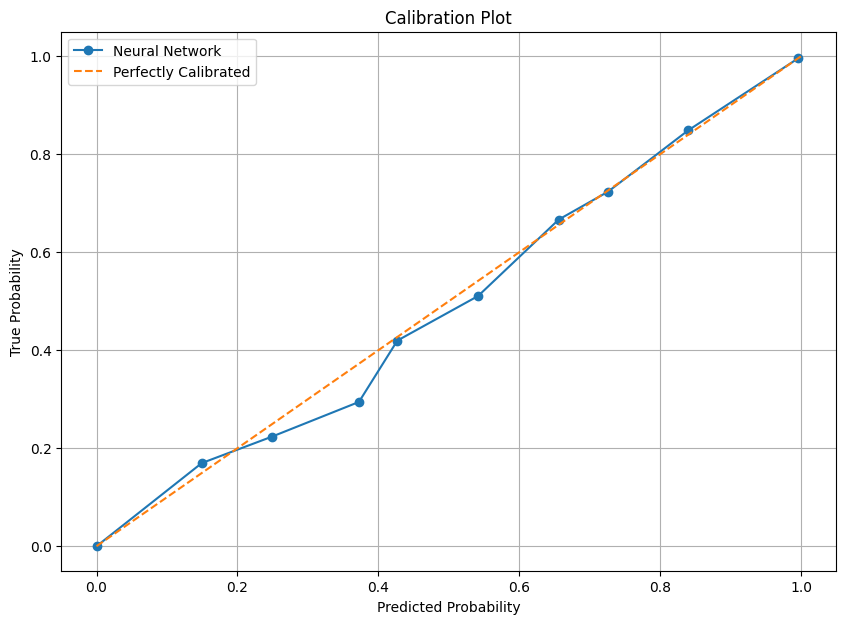

[0.01029353 0.21875    0.25925926 0.30555556 0.36734694 0.3125
 0.36734694 0.44137931 0.55639098 0.71106095]


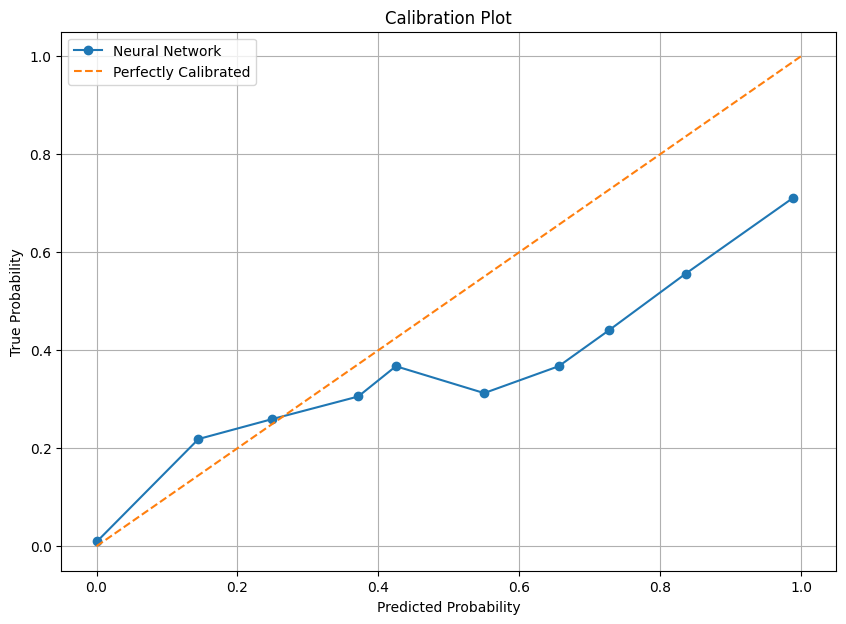

Neural Network Model AUC: 0.940 (0.931, 0.948)
Neural Network Model AUC: 0.940 (0.931, 0.948)


In [195]:
with torch.no_grad():
    y_pred_prob_nn_bb_train_missing = model_nn_bb(X_train_tensor_missing).numpy().reshape(-1)
    y_pred_prob_nn_bb_test_missing = model_nn_bb(X_test_tensor_missing).numpy().reshape(-1)

# Assuming y_test_tensor and y_pred_prob_nn_bb are already defined
y_train_numpy = y_train_tensor.numpy().reshape(-1)  # Convert y_test_tensor to numpy array

# Create a DataFrame
data = pd.DataFrame({'outcome': y_train_numpy, 'score': y_pred_prob_nn_bb_train_missing})

# Fit a Logistic GAM model
gam = LogisticGAM(s(0)).fit(data['score'], data['outcome'])
spnow = gam.lam

# Predict using the GAM model
y_pred_prob_nn_bb_calib_train_missing = gam.predict_proba(data['score'])

print(is_monotonic(y_pred_prob_nn_bb_calib_train_missing, y_train_numpy, n_bins=10))

if not is_monotonic(y_pred_prob_nn_bb_calib_train_missing, y_train_numpy, n_bins=10):
    print("GAM not yet monotonic, tune!!!")
    # Tune smoothing parameter to achieve monotonicity
    tunes = np.logspace(-3, 3, 10)
    for tune in tunes:
        tune = float(tune)
        gam = LogisticGAM(s(0),lam=spnow[0][0]*tune).fit(data['score'], data['outcome'])
        y_pred_prob_nn_bb_calib_train_missing = gam.predict_proba(data['score'])
        if is_monotonic(y_pred_prob_nn_bb_calib_train_missing, y_train_numpy, n_bins=10):
            print(f"Monotonicity achieved with sp = {spnow[0][0] * tune}")
            break

# Use the final calibrated predictions
y_pred_prob_nn_bb_calib_test_missing = gam.predict_proba(y_pred_prob_nn_bb_test_missing)

# Calculate calibration curve
prob_true, prob_pred = calibration_curve(y_train_numpy, y_pred_prob_nn_bb_calib_train_missing, n_bins=10)
print(prob_true)

# Plot calibration curve
plt.figure(figsize=(10, 7))
plt.plot(prob_pred, prob_true, marker='o', linestyle='-', label='Neural Network')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.title('Calibration Plot')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.legend()
plt.grid()
plt.show()

# Calculate calibration curve
prob_true, prob_pred = calibration_curve(y_test_numpy, y_pred_prob_nn_bb_calib_test_missing, n_bins=10)
print(prob_true)

# Plot calibration curve
plt.figure(figsize=(10, 7))
plt.plot(prob_pred, prob_true, marker='o', linestyle='-', label='Neural Network')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.title('Calibration Plot')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.legend()
plt.grid()
plt.show()

# Calculate AUC
auc_ffn, ci_ffn = roc_auc_score(y_test,
                        y_pred_prob_nn_bb_test_missing,
                        confidence_level=0.95)

print(f'Neural Network Model AUC: {auc_ffn:.3f} ({ci_ffn[0]:.3f}, {ci_ffn[1]:.3f})')

# Calculate AUC
auc_ffn, ci_ffn = roc_auc_score(y_test,
                        y_pred_prob_nn_bb_calib_test_missing,
                        confidence_level=0.95)

print(f'Neural Network Model AUC: {auc_ffn:.3f} ({ci_ffn[0]:.3f}, {ci_ffn[1]:.3f})')

#### Test 1: Is Distillation still possible?

In [196]:
# y_pred_lr_train_calib_missing
# y_pred_lr_test_calib_missing
# y_pred_rf_train_calib_missing
# y_pred_rf_test_calib_missing
# y_pred_prob_nn_bb_calib_train_missing
# y_pred_prob_nn_bb_calib_test_missing

auc_lr_lr, rmse_lr_lr = evaluate_mimic_model(X_train_missing_scaled, X_test_missing_scaled, y_pred_lr_train_calib_missing, 'lr', 'lr', y_test, y_pred_lr_test_calib_missing)
auc_lr_lr, rmse_lr_lr = evaluate_mimic_model(X_train_missing_scaled, X_test_missing_scaled, y_pred_lr_train_calib_missing, 'lr', 'lasso', y_test, y_pred_lr_test_calib_missing)
auc_xgb_lr, rmse_xgb_lr = evaluate_mimic_model(X_train_missing_scaled, X_test_missing_scaled, y_pred_rf_train_calib_missing, 'rf', 'lr', y_test, y_pred_rf_test_calib_missing)
auc_xgb_lr, rmse_xgb_lr = evaluate_mimic_model(X_train_missing_scaled, X_test_missing_scaled, y_pred_rf_train_calib_missing, 'rf', 'lasso', y_test, y_pred_rf_test_calib_missing)
auc_nn_lr, rmse_nn_lr = evaluate_mimic_model(X_train_missing_scaled, X_test_missing_scaled, y_pred_prob_nn_bb_calib_train_missing, 'nn', 'lr', y_test, y_pred_prob_nn_bb_calib_test_missing)
auc_nn_lr, rmse_nn_lr = evaluate_mimic_model(X_train_missing_scaled, X_test_missing_scaled, y_pred_prob_nn_bb_calib_train_missing, 'nn', 'lasso', y_test, y_pred_prob_nn_bb_calib_test_missing)

AUC of lr bb and lr mimic model:  0.963 (0.957, 0.969)
RMSE between lr black box prediction and lr mimic model prediction: 18796441624.8638
AUC of lr bb and lasso mimic model:  0.967 (0.962, 0.971)
RMSE between lr black box prediction and lasso mimic model prediction: 0.0774
AUC of rf bb and lr mimic model:  0.956 (0.951, 0.962)
RMSE between rf black box prediction and lr mimic model prediction: 9445653451.9519
AUC of rf bb and lasso mimic model:  0.958 (0.954, 0.963)
RMSE between rf black box prediction and lasso mimic model prediction: 0.0383
AUC of nn bb and lr mimic model:  0.964 (0.959, 0.970)
RMSE between nn black box prediction and lr mimic model prediction: 21938873072.1174
AUC of nn bb and lasso mimic model:  0.967 (0.963, 0.972)
RMSE between nn black box prediction and lasso mimic model prediction: 0.1084


#### Test 2: Feature importance detection

In [202]:
######################################################################################
######################################################################################
######################################################################################

mimic_model_lr_for_lrbb_missing = LinearRegression()
mimic_model_lr_for_lrbb_missing.fit(X_train_missing_scaled, y_pred_lr_train_calib_missing)

LinearRegression()

In [203]:
# Extracting coefficients
coefficients_lr_for_lrbb_missing = mimic_model_lr_for_lrbb_missing.coef_
print(coefficients_lr_for_lrbb_missing.max())
print(coefficients_lr_for_lrbb_missing.min())

feature_names = X_train.columns

# Creating a dataframe for coefficients and feature names
coef_df_lr_for_lrbb_missing = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients_lr_for_lrbb_missing
})

# print(coef_df[coef_df['Feature']=='ICD10_V74'])

# # Sorting by absolute value of the coefficients
# coef_df['abs_coef'] = coef_df['Coefficient'].abs()
# coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

# # Getting the top 10 positive and top 10 negative features
# top_features = pd.concat([coef_df.head(5), coef_df.tail(5)])

# # Plotting the coefficients
# plt.figure(figsize=(10, 8))
# plt.barh(top_features['Feature'], top_features['Coefficient'], color=np.where(top_features['Coefficient'] > 0, 'g', 'r'))
# plt.xlabel('Coefficient Value')
# plt.ylabel('Feature')
# plt.title('Top 10 Positive and Negative Features')
# plt.axvline(x=0, color='grey', linestyle='--')
# plt.show()

# print(top_features['Coefficient'])

156370703244.70255
-204701909200.43607


In [206]:
percentiles = []
feat_values = []
for feature in top_features_name:
    coef_value = coef_df_lr_for_lrbb_missing[coef_df_lr_for_lrbb_missing['Feature']==feature]['Coefficient'].item()
    print(coef_value)
    feat_values.append(coef_value)
    percentile = percentileofscore(coef_df_lr_for_lrbb_missing['Coefficient'], coef_value)
    percentiles.append(percentile)
    
    
coef_perc_df_missing = pd.DataFrame({
    'Feature': top_features_name[::-1],
    'coefficient': feat_values[::-1],
    'Percentile': percentiles[::-1]
})

display(coef_perc_df_missing)

0.0008258819580078125
0.0003039836883544922
-0.00021839141845703125
4.947185516357422e-05
-0.0003743767738342285
0.021388739347457886
0.013626426458358765
0.033577561378479004
0.03769460320472717
172239300.30868167


,Feature,coefficient,Percentile
0,age,1.722393e+08,98.539435
1558,ICD10_Z51,3.769460e-02,98.515093
4050,ICD9_967.1,3.357756e-02,98.490750
3227,ICD10_5A1,1.362643e-02,98.417722
1569,ICD10_Z66,2.138874e-02,98.466407
3834,ICD9_684.1,-3.743768e-04,20.642648
2150,ICD9_642,4.947186e-05,59.359786
2061,ICD9_540,-2.183914e-04,30.574489
3374,ICD9_064,3.039837e-04,79.576436
4020,ICD9_893.1,8.258820e-04,91.480039


In [207]:
# Fit the LASSO model
lasso_model_lr_lasso_missing = Lasso(alpha=0.001, random_state=42)  # Adjust alpha as needed
lasso_model_lr_lasso_missing.fit(X_train_missing_scaled, y_pred_lr_train_calib_missing)

# 
# Extracting coefficients
coefficients_lasso_for_lrbb_missing = lasso_model_lr_lasso_missing.coef_
print(coefficients_lasso_for_lrbb_missing.max())
print(coefficients_lasso_for_lrbb_missing.min())

feature_names = X_train.columns

# Creating a dataframe for coefficients and feature names
coef_df_lasso_for_lrbb_missing = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients_lasso_for_lrbb_missing
})

0.03542055925938023
-0.007396355437310421


In [209]:
percentiles = []
feat_values = []
for feature in top_features_name:
    coef_value = coef_df_lasso_for_lrbb_missing[coef_df_lasso_for_lrbb_missing['Feature']==feature]['Coefficient'].item()
    print(coef_value)
    feat_values.append(coef_value)
    percentile = percentileofscore(coef_df_lasso_for_lrbb_missing['Coefficient'], coef_value)
    percentiles.append(percentile)
    
    
coef_perc_df_missing_lr_lasso = pd.DataFrame({
    'Feature': top_features_name[::-1],
    'coefficient': feat_values[::-1],
    'Percentile': percentiles[::-1]
})

display(coef_perc_df_missing_lr_lasso)

0.0
0.0
0.0
0.0
-0.0
0.022042642434843437
0.008975121539517421
0.032534873114232976
0.03542055925938023
0.0


,Feature,coefficient,Percentile
0,age,0.000000,50.133885
1558,ICD10_Z51,0.035421,100.000000
4050,ICD9_967.1,0.032535,99.975657
3227,ICD10_5A1,0.008975,99.780915
1569,ICD10_Z66,0.022043,99.951315
3834,ICD9_684.1,-0.000000,50.133885
2150,ICD9_642,0.000000,50.133885
2061,ICD9_540,0.000000,50.133885
3374,ICD9_064,0.000000,50.133885
4020,ICD9_893.1,0.000000,50.133885


#### For rf model

In [212]:
######################################################################################
######################################################################################
######################################################################################

mimic_model_lr_for_rfbb_missing = LinearRegression()
mimic_model_lr_for_rfbb_missing.fit(X_train_missing_scaled, y_pred_rf_train_calib_missing)

# Extracting coefficients
coefficients_lr_for_rfbb_missing = mimic_model_lr_for_rfbb_missing.coef_
print(coefficients_lr_for_rfbb_missing.max())
print(coefficients_lr_for_rfbb_missing.min())

feature_names = X_train.columns

# Creating a dataframe for coefficients and feature names
coef_df_lr_for_rfbb_missing = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients_lr_for_rfbb_missing
})

percentiles = []
feat_values = []
for feature in top_features_name_rf:
    coef_value = coef_df_lr_for_rfbb_missing[coef_df_lr_for_rfbb_missing['Feature']==feature]['Coefficient'].item()
    print(coef_value)
    feat_values.append(coef_value)
    percentile = percentileofscore(coef_df_lr_for_rfbb_missing['Coefficient'], coef_value)
    percentiles.append(percentile)
    
    
coef_perc_df_missing = pd.DataFrame({
    'Feature': top_features_name_rf[::-1],
    'coefficient': feat_values[::-1],
    'Percentile': percentiles[::-1]
})

display(coef_perc_df_missing)

68754120580.03017
-67425720972.37939
0.008980616927146912
0.006235480308532715
0.01003718376159668
0.011915922164916992
0.014786407351493835
0.012036126106977463
0.018838539719581604
0.017768383026123047
0.023473262786865234
-281971866.12823004


,Feature,coefficient,Percentile
2688,ICD9_V66,-2.819719e+08,0.632911
1569,ICD10_Z66,2.347326e-02,98.490750
4050,ICD9_967.1,1.776838e-02,98.442064
1558,ICD10_Z51,1.883854e-02,98.466407
669,ICD10_J96,1.203613e-02,98.344693
2878,ICD10_0BH,1.478641e-02,98.417722
1629,ICD9_038,1.191592e-02,98.320351
2274,ICD9_785,1.003718e-02,98.271665
2039,ICD9_518,6.235480e-03,98.076923
3227,ICD10_5A1,8.980617e-03,98.222980


In [213]:
# Fit the LASSO model
lasso_model_rf_lasso_missing = Lasso(alpha=0.001, random_state=42)  # Adjust alpha as needed
lasso_model_rf_lasso_missing.fit(X_train_missing_scaled, y_pred_rf_train_calib_missing)

# 
# Extracting coefficients
coefficients_lasso_for_rfbb_missing = lasso_model_rf_lasso_missing.coef_
print(coefficients_lasso_for_rfbb_missing.max())
print(coefficients_lasso_for_rfbb_missing.min())

feature_names = X_train.columns

# Creating a dataframe for coefficients and feature names
coef_df_lasso_for_rfbb_missing = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients_lasso_for_rfbb_missing
})

percentiles = []
feat_values = []
for feature in top_features_name:
    coef_value = coef_df_lasso_for_rfbb_missing[coef_df_lasso_for_rfbb_missing['Feature']==feature]['Coefficient'].item()
    print(coef_value)
    feat_values.append(coef_value)
    percentile = percentileofscore(coef_df_lasso_for_rfbb_missing['Coefficient'], coef_value)
    percentiles.append(percentile)
    
    
coef_perc_df_missing_rf_lasso = pd.DataFrame({
    'Feature': top_features_name_rf[::-1],
    'coefficient': feat_values[::-1],
    'Percentile': percentiles[::-1]
})

display(coef_perc_df_missing_rf_lasso)

0.023620036537967324
-0.003118201039963407
0.0006489007847637093
0.0
0.0
0.0
0.0
0.023620036537967324
0.005705538049792598
0.018417764442393427
0.01674379865214751
0.0


,Feature,coefficient,Percentile
2688,ICD9_V66,0.000000,49.476631
1569,ICD10_Z66,0.016744,99.951315
4050,ICD9_967.1,0.018418,99.975657
1558,ICD10_Z51,0.005706,99.586173
669,ICD10_J96,0.023620,100.000000
2878,ICD10_0BH,0.000000,49.476631
1629,ICD9_038,0.000000,49.476631
2274,ICD9_785,0.000000,49.476631
2039,ICD9_518,0.000000,49.476631
3227,ICD10_5A1,0.000649,98.612463
